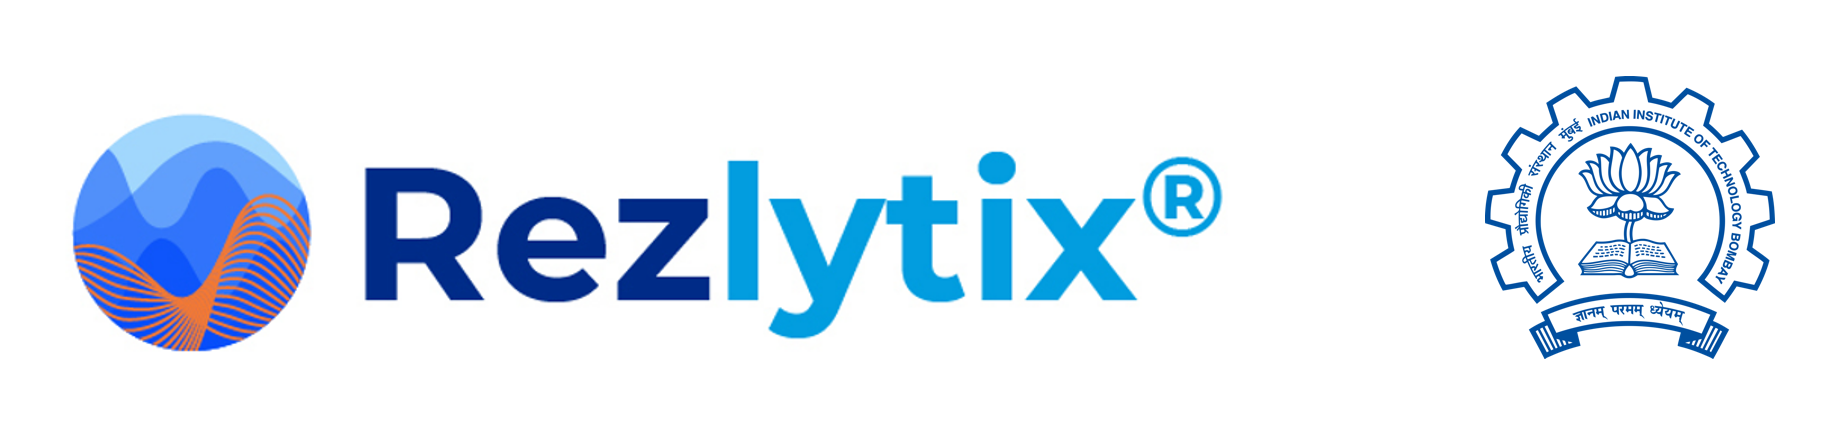

# Building a web app for an ML application

We shall build a dash app to impute missing data in well logs using machine learning.

## Notebook overview
- Dash Web App creation
    - Layout definition
    - Callbacks definition

- During this session, we shall also touch upon the following topic
    - EDA and its importance
    - Hyperparameter tuning<br>
        Limited hyperparameter search due to resource constraints on a notebook.
    - Evaluation of different models

## Initial setup

In [1]:
##### Applicable only if you are running this notebook on Colab. Disable otherwise.
##### Mount your google drive to this notebook. It will require some permissions.

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
# Create a base working directory for this workshop
import os
# base_dir = "/content/drive/My Drive/<Your_desired_folder_name>"     # Please change path / folder name to something you desire. 
base_dir = "/content/drive/My Drive/Test"

if not os.path.isdir(base_dir):
    os.mkdir(base_dir)

if not os.path.isdir(base_dir + "/loaded"):
    os.mkdir(base_dir + "/loaded")

os.chdir(base_dir)

In [3]:
all_loaded_files = os.listdir(base_dir+'/loaded/')
well_las_xrs = [file for file in all_loaded_files if 'LAS' in file]

# Choosing just 4 wells since to speed things up
wells_list  = ['15_9-F-11A',  '15_9-F-1A', '15_9-F-1B',  '15_9-F-11T2']

well_las_xrs = [file for file in well_las_xrs for well in wells_list if well in file]

In [4]:
well_las_xrs

['15_9-F-1A_LAS.nc',
 '15_9-F-11A_LAS.nc',
 '15_9-F-11T2_LAS.nc',
 '15_9-F-1B_LAS.nc']

### Required libraries

In [5]:
!pip install dash
!pip install jupyter_dash
!pip install dash-mantine-components
 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# Dash
import dash
from dash import Input, Output, State, dcc, html, callback, dash_table
from jupyter_dash import JupyterDash
import dash_mantine_components as dmc
from dash.exceptions import PreventUpdate

# Scientific and data analysis libraries
import pandas as pd
import numpy as np
import xarray as xr
import scipy
from scipy.interpolate import RectBivariateSpline as RBVS

# Plotting
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML libraries
import sklearn
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

import json
import joblib
import pickle

## Web app definition

In [7]:
app = JupyterDash(
        name = __name__,
        suppress_callback_exceptions=True,
    )

In a normal dev environment the "JupyterDash" would be replaced by dash.Dash

In [8]:
page_name = "log-ai"
logs = ['NPHI','RHOB','GR','RT','PEF','CALI','DT','DTS',]

In [9]:
# Function to plot logs
def custom_logplot(well_name, well_df, logs):
    # well_df = well_df[well_df.WELL==well]
    
    z = len(logs)
    logs.append('DEPTH')
    well_df = well_df[logs]

    fig = make_subplots(rows=1, cols=z,shared_yaxes=True)
    
    counter = 0
    for i in logs:
        if i == 'GR':
            counter+=1
            fig.add_trace(go.Scatter(x=well_df['GR'],y =well_df['DEPTH'],line_color='forestgreen',fillcolor='forestgreen',fill = 'tozerox'),row=1,col=counter)
            
            fig.update_xaxes(title_text='GR',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',range=[0,200],dtick=200,minor_griddash='solid',
            gridcolor='LightGreen')
            
            fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')
        
        elif i == 'CALI':
            counter +=1
            if 'BS' in logs:
                fig.add_trace(go.Scatter(x=well_df['CALI'],y =well_df['DEPTH'],line_color='black'),row=1,col=counter,)
                fig.add_trace(go.Scatter(x=well_df['BS'],y =well_df['DEPTH'],line_color='red',name='BS'),row=1,col=counter,)
                fig.update_xaxes(title_text='CALI',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',range=[0,20],gridcolor='LightGreen')
                fig.update_xaxes(title_text='BS',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',range=[0,20],gridcolor='LightGreen')
                fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')

            else:
               fig.add_trace(go.Scatter(x=well_df['CALI'],y =well_df['DEPTH'],line_color='black'),row=1,col=counter,)
               fig.update_xaxes(title_text='CALI',row=1,col=2,title_standoff=1,tickson="boundaries",ticks= 'outside',range=[0,20],gridcolor='LightGreen')
               fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')

        elif i == 'NPHI':
            counter += 1
            fig.add_trace(go.Scatter(x=well_df['NPHI'],y =well_df['DEPTH'],line_color='darkblue',),row=1,col=counter)
            fig.update_xaxes(title_text='NPHI',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',gridcolor='LightGreen')
            fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')
        
        elif i == 'RHOB':
            counter += 1
            fig.add_trace(go.Scatter(x=well_df['RHOB'],y =well_df['DEPTH'],line_color='brown',line={'dash':'dash'}),row=1,col=counter)
            fig.update_xaxes(title_text='RHOB',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',gridcolor='LightGreen')
            fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')     
        
        elif i == 'RT':
            counter += 1
            fig.add_trace(go.Scatter(x=well_df['RT'],y =well_df['DEPTH'],line_color='black'),row=1,col=counter,)
            fig.update_xaxes(title_text='RT',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',type = 'log',
                gridcolor='LightGreen',range=[-1,3],showgrid=True, dtick=1,minor_griddash='solid',showline= True, mirror = True,linecolor='#DBE3EF')
            fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')

        elif i == 'PEF':
            counter+=1
            fig.add_trace(go.Scatter(x=well_df['PEF'],y =well_df['DEPTH']),row=1,col=counter)
            fig.update_xaxes(title_text='PEF',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',range=[0,10],gridcolor='LightGreen')
            fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')
        
        elif i == 'DTS':
            counter +=1
            fig.add_trace(go.Scatter(x=well_df['DTS'],y =well_df['DEPTH']),row=1,col=counter)
            fig.update_xaxes(title_text='DTS',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',gridcolor='LightGreen')
            fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')
        
        elif i == 'DT':
            counter +=1
            fig.add_trace(go.Scatter(x=well_df['DT'],y =well_df['DEPTH']),row=1,col=counter)
            fig.update_xaxes(title_text='DTC',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',gridcolor='LightGreen')
            fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')

        elif i == 'AI':
            counter +=1
            fig.add_trace(go.Scatter(x=well_df['AI'],y =well_df['DEPTH']),row=1,col=counter)
            fig.update_xaxes(title_text='AI',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',gridcolor='LightGreen')
            fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')

        elif i == 'SI':
            counter +=1
            fig.add_trace(go.Scatter(x=well_df['SI'],y =well_df['DEPTH']),row=1,col=counter)
            fig.update_xaxes(title_text='SI',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',gridcolor='LightGreen')
            fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')

        elif i == 'VPVS':
            counter +=1
            fig.add_trace(go.Scatter(x=well_df['VPVS'],y =well_df['DEPTH']),row=1,col=counter)
            fig.update_xaxes(title_text='VPVS',row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',gridcolor='LightGreen')
            fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')
        
    
    fig.update_yaxes(title_text='DEPTH',row=1,col=1,autorange='reversed',gridcolor='LightGreen')

    
    fig.update_xaxes({'side':'top'})
    fig.update_layout(title_text=well_name,title_x=0.5,
    showlegend=False, paper_bgcolor="#DBE3EF",plot_bgcolor="white")
    return fig


In [10]:
def blank_fig(height = 1000, width = 600):
        fig = go.Figure(go.Scatter(x=[], y=[]))
        fig.update_layout(template=None, height=height, width=width)
        fig.update_xaxes(showgrid=False, showticklabels=False, zeroline=False)
        fig.update_yaxes(showgrid=False, showticklabels=False, zeroline=False)

        return fig

### Layout definition

In [11]:
target_features = logs

def layout_creator():
    component = html.Div([
        dmc.Space(h=10),

        #################################
        #### Well Explorer components ###
        #################################
        
        html.Div([
            html.H1('Well Data Explorer', id = f"explore_well")
        ]),        
        dmc.Space(h=20),
        
        # Well Select + Basemap
        html.Div([
            html.H2("Well Selection"),
            # dmc.Group([
            dmc.Paper([
                    dmc.Container([
                            dmc.Title("Select Well", order = 4, align ="left", 
                                    style={'color': '#163f5d','fontSize': '20px','backgroundColor':'white','margin-left': '0%','textAlign': 'left','font-family':'Helvetica'}),
                            
                            dmc.Select(id=f"{page_name}-well-select", data=wells_list, placeholder="Select Well",
                                        required=True,searchable=True, nothingFound="No such well available",
                                        style={"width":300}, radius="md", shadow="xl"),
                            
                            dmc.Space(h=10),
                            
                            dmc.Title("Available Logs", order = 4, align ="left", 
                                    style={'color': '#163f5d','fontSize': '20px','backgroundColor':'white','margin-left': '0%','textAlign': 'left','font-family':'Helvetica'}),
                            dmc.MultiSelect(id=f"{page_name}-available-logs", data=[], 
                                            searchable=True, clearable=True, nothingFound="No such logs available",
                                            style={"width":600}, radius="md", shadow="xl"),
                            dmc.Space(h=10),
                           
                    ])
            ], style={"height":200}),

            # ], position = "left", spacing = "xl", align="flex-start"),
            dmc.Space(h=10),
        ] ),
        dmc.Space(h=10),
        
        # Well log Viz  
        html.Div([
            html.H2("Well Logs Visualization"),
            dmc.Space(h=20),
            dmc.Container([
                dmc.Skeleton(height = 780, width =1780, radius="lg"),
            ], fluid=True, id=f"{page_name}-well-log-viz"),
            dmc.Space(h=10),
        ] ),
        dmc.Space(h = 10),
        
        # Missing Data Viz, Pearson Corr
        dmc.Group([
            html.Div([
                html.H2("Missing Logs Data visualization"),
                dmc.Space(h=10),
                dmc.Container([
                    dmc.Skeleton(height = 880, width =880, radius="lg"),
                ], id=f"{page_name}-missing-log-viz", fluid=True),
                dmc.Space(h=10),
            ] ),

            html.Div([
                html.H2("Pearson Correlation"),
                dmc.Space(h=10),
                dmc.Container([
                    dmc.Skeleton(height = 880, width=880, radius="lg"),
                ], id=f"{page_name}-pearson-correlation", fluid=True),
                dmc.Space(h=10),
            ] ),
        ], position="left", spacing = "xl"),
        dmc.Space(h=10),
        
        # Scatter Plots
        html.Div([
            html.H2("Scatter Distribution"),
            dmc.Space(h=10),
            dmc.Group([
                dmc.Space(w=7),
                dmc.NumberInput(id=f"{page_name}-pair-plot-resampler",value=10, radius="md", label = "Resample value",
                                 required=True, step = 1, style = {"width": 200}),
            ]),
            dmc.Space(h=10),
            dmc.Container([
                dmc.Skeleton(height = 1740, width =1780, radius="lg"),
            ], id=f"{page_name}-pair-plot", fluid=True),
            dmc.Space(h=10),
        ] ),
        
        # dmc.Group([
        #     dmc.Button("Shortlist well for Blind Validation", color="blue", id = f"{page_name}-blind_validation_button"),
        #     dmc.Button([
        #         dbc.Nav([dbc.NavLink("Explore another well", href=f"#explore_well", external_link=True, style={"color":"white"})]),
        #     ]),
        # ], direction='row', spacing='lg'),

        #################################
        #### Log AI components ##########
        #################################
        
        dcc.Store(id = 'log-ai-params-list',data=[],storage_type='session'),
        dcc.Store(id = 'log-ai-store-res',data=[],storage_type='session'),     
        dcc.Store(id = 'log-ai-x-train',data=[],storage_type='session'),
        dcc.Store(id = 'log-ai-y-train',data=[],storage_type='session'),
        dcc.Store(id = 'log-ai-x-test',data=[],storage_type='session'),
        dcc.Store(id = 'log-ai-y-test',data=[],storage_type='session'),
        dcc.Store(id = 'log-ai-well-ai-final',data=[],storage_type='session'),
        dcc.Store(id = 'log-ai-well-org-final',data=[],storage_type='session'),

        dmc.Space(h=10),
        html.Div([
            html.H1('Well Log AI', id=f"{page_name}")
        ]),  
        dmc.Space(h=10),
        
        # Hyperparameter Tuning Section
        html.Div([
            html.H2("Hyperparameter Tuning"),
            dmc.Space(h=10),    
            dmc.Container([        
            dmc.Group([
                        dmc.Select(id=f"{page_name}-target-check", data=target_features, searchable=True, required=True, nothingFound="Log not available", 
                                   placeholder="Select Target Log", label = "Select Target Log", style={"width":300}, radius="md", shadow="xl"),
                        
                        dmc.MultiSelect(id=f"{page_name}-features-check", data=[], label = "Select Features", placeholder = "Select Features",
                                        searchable=True, clearable=True, required=True, nothingFound="Please select Target Log first",
                                        style={"width":800}, radius="md", shadow="xl"),
            ], spacing = "lg"),
        
            dmc.Space(h=10),
            dmc.MultiSelect(id=f"{page_name}-wells-check", data=[], label = "Select Wells for Blind Validation", placeholder = "Select Wells for Blind Validation",
                                        searchable=True, clearable=True, required=True, nothingFound="Please select Target Log and features first",
                                        style={"width":800}, radius="md", shadow="xl"),
            
            dmc.Space(h=15),
            html.Div(dmc.Text("PLEASE WAIT. This message will update when you are ready to perform hyper-parameter search."), id = 'hidden-div2'),
            dmc.Space(h=10),
            dmc.Group([
                dmc.Button(id=f"{page_name}-hyperparam-search", children='Perform Hyperparameter Search', color="blue"),
                dmc.Space(w=10),
                html.Div(id='well-ai-hidden-div' , style={'display':'Success'}),
            ], spacing='lg'),
            dmc.Space(h=10),
            dash_table.DataTable(
                id = "ran-id",
                filter_action='native',
                fixed_rows={'headers': True},    
                page_action='none',
                style_table={'height': '300px', 'overflowY': 'auto','overflowX': 'auto'},
                style_data={'whiteSpace': 'normal','height': 'auto',},
                style_cell={
                    'overflow': 'hidden',
                    'textOverflow': 'ellipsis',
                    'maxWidth': 0,
                    'height': 'auto',
                    'minWidth': '180px', 'width': '180px', 'maxWidth': '150px',
                    'whiteSpace': 'normal',
                    'padding': '5px',
                    'fontSize':15, 'font-family':'sans-serif'},
                    
                style_header={
                    'backgroundColor': 'white',
                    'fontWeight': 'bold'}),
            dmc.Space(h=20),
            ], fluid = True)
        ] ),

        dmc.Space(h=20),

        #### Training results viz ####

        html.Div([
            html.H2("Training results Visualization (Compare top results)"),
            dmc.Container([
            dmc.Space(h=10),
            dmc.Group([
                dmc.Select(id = f"{page_name}-well-dd-test", data= wells_list, clearable=False, label = "Select blind well", placeholder = "Select Well",
                            style={"width":300}, radius="md", shadow="xl"),

                dmc.MultiSelect(id = f"{page_name}-ran-src-res", data= ['Rank1','Rank2', 'Rank3','Rank4','Rank5'], 
                                label= "Select results to visualize",
                                value=['Rank1','Rank2'], clearable=True,
                                style={"width":600}, radius="md", shadow="xl"),  
                dmc.Space(h=10),      
                html.Div(id = 'hidden-div3'),
                dmc.Space(h=10),      
                dmc.Group([
                    dmc.Space(h=10),
                    dmc.Button(id = 'submit-4',n_clicks =0, children ='Visualize Training Results', color="blue"),
                ] ),
            ], spacing = "lg"),
            dmc.Space(h=10),
            dcc.Graph(id = 'result-id',  style = {'height':900,'width':1800}, figure= blank_fig(height = 800, width = 1700)),
            ], fluid = True)
        ] )       
    ])

    return component


app.layout = layout_creator()        


### Callbacks

#### EDA callbacks

In [12]:
# Helper function to load xarray files to a dataframe
def load_xarray_to_df(well_name: str):
        xr_file = [file for file in well_las_xrs if well_name in file][0]
        well_xr = xr.open_dataset(base_dir + '/loaded/' + xr_file)
        well_df = well_xr.to_dataframe()
        return well_df

In [13]:
@app.callback(
    Output(f"{page_name}-available-logs", 'data'),
    Output(f"{page_name}-available-logs", 'value'),
    Input(f"{page_name}-well-select", 'value'),
    prevent_initial_call=True
)
def get_available_logs(well):
    well_df = load_xarray_to_df(well_name = well)
    all_logs = well_df.columns.to_list()
    return all_logs, all_logs

In [14]:
''' Well Log Visualization'''
@app.callback(
    Output(f"{page_name}-well-log-viz",'children'),
    Input(f"{page_name}-available-logs", 'value'),
    State(f"{page_name}-well-select",'value'),
    prevent_initial_call=True
)
def well_log_visualizer(logs_in_xr, well):
    if not well:
        raise PreventUpdate
    else:
        well_df = load_xarray_to_df(well_name = well)
        well_df.reset_index(inplace=True)

        fig = custom_logplot(well, well_df, logs_in_xr)
        component = dcc.Graph(figure=fig, style = {'height':780,'width':1780})
        return component

In [15]:
'''Missing Bar'''
@app.callback(
    Output(f"{page_name}-missing-log-viz","children"),
    Input(f"{page_name}-well-select","value"),
    prevent_initial_call=True
)
def missing_logs_viz(well_name):
    well_df = load_xarray_to_df(well_name = well_name)
    well_df.reset_index(inplace=True)
    
    list1 = well_df.columns.to_list()
    list1.remove('DEPTH')
    list2=[]
    list3 =[]
    for i in list1:
        list2.append(len(well_df[i].dropna()))
    
    max_val = max(list2)
    for i in list2:
        list3.append((i/max_val)*100)
    
    df_bar = pd.DataFrame({'Features':list1,'Data points':list2,'Percentage':list3})
    
    fig = px.bar(df_bar,x = 'Features', y = 'Percentage',title = well_name,text='Data points')
    fig.update_layout(yaxis_title = "Percentage Availability (%)")  
    component = dcc.Graph(figure=fig, style={'height':880, 'width':880})
    return component


'''Pearson Correlation'''
@app.callback(
    Output(f"{page_name}-pearson-correlation","children"),
    Input(f"{page_name}-well-select","value"),
    prevent_initial_call=True
)
def pearson_correlation(well_name):
    well_df = load_xarray_to_df(well_name = well_name)

    fig = px.imshow(well_df.corr().round(2), text_auto=False)
    fig.update_layout(height=860, width=860)    
    component = dcc.Graph(figure=fig, style={'height':880, 'width':880})
    return component


In [16]:
'''Scatter-Pair plot'''
@app.callback(
    Output(f"{page_name}-pair-plot","children"),
    Input(f"{page_name}-well-select","value"),
    Input(f"{page_name}-pair-plot-resampler","value"),
    prevent_initial_call=True
)
def scatterplot(well_name,resample_value):
    well_df = load_xarray_to_df(well_name = well_name)
    resample_value = int(resample_value)
    resampled = well_df.iloc[::resample_value, :]
    listofparas = well_df.columns.to_list()

    fig = px.scatter_matrix(resampled)
    fig.update_traces(marker=dict(size=2,line=dict(width=0.1965,
                                        color='black')))
    component = dcc.Graph(figure=fig,style={'height':1740,'width':1800}),
    return component

#### AI callbacks

In [17]:
@app.callback(
    Output(f"{page_name}-features-check", 'data'),
    Input(f"{page_name}-target-check", 'value'),
    prevent_initial_call = True
)
def check_features(target):
    if not target:
        return dash.no_update
    else:
        features_check_new = logs.copy()
        features_check_new.remove(target)
        return features_check_new

In [18]:
#Test wells
@app.callback(
    Output(f"{page_name}-wells-check",'data'),
    Input(f"{page_name}-target-check",'value'),
    Input(f"{page_name}-features-check",'value'),
    prevent_initial_call = True
)
def two(target,features):
    if not (target and features):
        return dash.no_update
    if not (target or features):
        return dash.no_update
    else:
        return wells_list

In [19]:
'''#Preparing data  @ dcc store'''
@app.callback(
    Output('log-ai-x-train','data'),
    Output('log-ai-y-train','data'),
    Output('log-ai-x-test','data'),
    Output('log-ai-y-test','data'),
    Output('hidden-div2','children'),
    Input(f"{page_name}-wells-check", 'value'),
    State(f"{page_name}-target-check",'value'),
    State(f"{page_name}-features-check",'value'),
    prevent_initial_call = True
)
#Data Preparation
def data_preparation(test_wells, target, features):
    if not test_wells:
        raise PreventUpdate
    else:
        # train_wells = [well for well in wells_list if well not in test_wells]
        wells_df = well_df = load_xarray_to_df(well_name = wells_list[0])
        wells_df.reset_index(inplace = True) 
        wells_df['WELL'] = wells_list[0]
        for well in wells_list[1:]:
            well_df = load_xarray_to_df(well_name = well)
            well_df['WELL'] = well
            well_df.reset_index(inplace = True) 
            wells_df = pd.concat([wells_df,well_df])
        
        a = ['WELL','DEPTH']
        target_list = [target]
        #dataframe columns include - 'WellName'+'Depth'+ Target variable (user-defined) and Feature Logs (user-defined)
        cols = a + features + target_list 
        
        wells_df = wells_df[cols]
        wells_df = wells_df.dropna()
        wells_df = wells_df.reset_index(drop='True')
        
        sc = StandardScaler()

        def scaleColumns(df,tgt):
        #df: dataframe with features and target columns
        #tgt: target log
            df1 = df.copy()
            df1 = df1.drop(columns=(['WELL',tgt]))
            scaled_features = sc.fit_transform(df1.values)
            df2 = pd.DataFrame(scaled_features, index=df.index, columns=df1.columns)
            df2[target] = df[tgt]
            df2['WELL'] = df.WELL
            #To use Standard Scaler again:
            joblib.dump(sc, 'std_scaler.bin', compress=True)
            # Use  ''sc=joblib.load('std_scaler.bin')'' to load the transformation model
            return df2
        
        def train_test_split(df,test_wells):
            #wellname: list of well names that are to be dropped from the training dataset
            test = df[df['WELL'].isin(test_wells)]
            test = test.reset_index(drop=True)
            train = df[~df['WELL'].isin(test_wells)]
            train = train.reset_index(drop=True)
            return train,test

        def dataPrep(train, test, tgt_log):
        #Separating out X and Y from training and testing datasets
            x_train = train.drop(columns=f"{tgt_log}")
            x_test = test.drop(columns=f"{tgt_log}")

            y_train = train[f"{tgt_log}"]
            y_test = test[f"{tgt_log}"]

            return x_train,y_train,x_test,y_test

        scaled_df = scaleColumns(wells_df, target) #Scaling
        train,test = train_test_split(scaled_df, test_wells) #Train Test Split
        X_train_input,Y_train_input,X_test_input,Y_test_input = dataPrep(train, test, target)#X and Y split
        
        
        Y_train_input = pd.DataFrame({target:Y_train_input})
        Y_test_input = pd.DataFrame({target:Y_test_input})

        return X_train_input.to_dict('record'), Y_train_input.to_dict('record'), X_test_input.to_dict('record'), Y_test_input.to_dict('record'), dmc.Text('Ready to perform Hyper-parameter search')


In [20]:
#hyper-parameter tuning for XGBoost
params = {
    "learning_rate" :[0.1,0.2],
    "max_depth" :[15],
    "colsample_bytree" : [0.1]
}

#Running the model
@app.callback(
    Output('well-ai-hidden-div','children'),
    Output('ran-id','data'),
    Output('ran-id','columns'),
    Output('log-ai-params-list','data'),
    Input(f"{page_name}-hyperparam-search",'n_clicks'),
    State('log-ai-x-train','data'),
    State('log-ai-y-train','data'),
    State('log-ai-x-test','data'),
    State('log-ai-y-test','data'),
    prevent_initial_call = True
)
#XGboost
def XGboost(n_clicks,X_train_input,Y_train_input,X_test_input,Y_test_input):
    if n_clicks:
        X_train_input = pd.DataFrame(X_train_input)
        Y_train_input = pd.DataFrame(Y_train_input)
        X_test_input = pd.DataFrame(X_test_input)
        Y_test_input = pd.DataFrame(Y_test_input)

        #Calling Xgb Regressor
        xg_reg = xgb.XGBRegressor()
        
        if len(X_train_input.columns) > 0:
                if "WELL" in X_train_input.columns:
                    X_train_input = X_train_input.drop(['WELL'], axis=1)
                if "WELL" in X_test_input.columns:
                    X_test_input = X_test_input.drop(['WELL'], axis=1)


                #Random Search Hyperparametr tuning for XGboost
                random_search = RandomizedSearchCV(xg_reg,param_distributions=params,n_iter = 5,n_jobs=-1,scoring='neg_mean_squared_error')
                random_search.fit(X_train_input,Y_train_input)
                #Displaying the best parameters

                #Fitting Xgboost with best parameters
                xg_reg = xgb.XGBRegressor(**random_search.best_params_)
                xg_reg.fit(X_train_input,Y_train_input)


                train_pred = xg_reg.predict(X_train_input)
                rmse_train = np.sqrt(mean_squared_error(Y_train_input, train_pred))
                test_pred = xg_reg.predict(X_test_input)
                rmse_test = np.sqrt(mean_squared_error(Y_test_input, test_pred))

                # save the model to disk
                filename = base_dir + 'xgb_finalized_model.sav'
                pickle.dump(xg_reg, open(filename, 'wb'))
                joblib.dump(random_search, 'random_src')

                ran_src = joblib.load('random_src')
                results = pd.DataFrame(ran_src.cv_results_)      
                results = results.sort_values('rank_test_score')
                randm_result = results[['rank_test_score','mean_test_score','params']]
                randm_result = randm_result.reset_index(drop=True)

                para_list = randm_result.head(5).params.to_list()

                randm_result[['Max_Depth','learning rate','colsample by tree']] = randm_result['params'].apply(pd.Series)
                randm_result = randm_result.drop(columns = 'params')
                randm_result.rename(columns = {'rank_test_score':'Ranks based on Error', 'mean_test_score':'Mean RMSE',
                'Max_Depth':'Max Depth of a Tree','learning rate':'Learning Rate','colsample by tree':'Column Sample by tree',}, inplace = True)
                rsrc_data = randm_result.to_dict('records')
                columns= [{'id': c, 'name': c} for c in randm_result.columns]
                return "Hyperparameter search: Success.", rsrc_data, columns, para_list
        else:
            return "Hyperparameter search: Please rerun", None, None, None
    else:
        return dash.no_update

In [21]:
@app.callback(
    Output('log-ai-store-res','data'),
    Output('hidden-div3','children'),
    Input('log-ai-params-list','data'),
    State('log-ai-x-train','data'),
    State('log-ai-y-train','data'),
    State('log-ai-x-test','data'),
    State('log-ai-y-test','data'),
    prevent_initial_call = True
 )

def train_params_save(params, X_train_input, Y_train_input, X_test_input, Y_test_input):
     if params:
        X_train_input = pd.DataFrame(X_train_input)
        Y_train_input = pd.DataFrame(Y_train_input)
        X_test_input = pd.DataFrame(X_test_input)
        Y_test_input = pd.DataFrame(Y_test_input)

        df_test= X_test_input.copy()


        X_train_input = X_train_input.drop(columns = 'WELL')
        X_test_input = X_test_input.drop(columns ='WELL')    

        xg_reg_1 = xgb.XGBRegressor(**params[0])
        xg_reg_1.fit(X_train_input,Y_train_input)
        joblib.dump(xg_reg_1, 'xg_reg_1.joblib')
        

        xg_reg_2 = xgb.XGBRegressor(**params[1])
        xg_reg_2.fit(X_train_input,Y_train_input)
        joblib.dump(xg_reg_2, 'xg_reg_2.joblib')

        # xg_reg_3 = xgb.XGBRegressor(**params[2])
        # xg_reg_3.fit(X_train_input,Y_train_input)
        # joblib.dump(xg_reg_3, 'xg_reg_3.joblib')

        # xg_reg_4 = xgb.XGBRegressor(**params[3])
        # xg_reg_4.fit(X_train_input,Y_train_input)
        # joblib.dump(xg_reg_4, 'xg_reg_4')

        # xg_reg_5 = xgb.XGBRegressor(**params[4])
        # xg_reg_5.fit(X_train_input,Y_train_input)
        # joblib.dump(xg_reg_5, 'xg_reg_5')

        Rank1 = xg_reg_1.predict(X_test_input)
        Rank2 = xg_reg_2.predict(X_test_input)
        # Rank3 = xg_reg_3.predict(X_test_input)
        # Rank4 = xg_reg_4.predict(X_test_input)
        # Rank5 = xg_reg_5.predict(X_test_input)

        df_test['Rank1'] = Rank1
        df_test['Rank2'] = Rank2
        # df_test['Rank3'] = Rank3
        # df_test['Rank4'] = Rank4
        # df_test['Rank5'] = Rank5
        df_test['Original'] = Y_test_input

        return df_test.to_dict('record'), dmc.Text("Ready to visualize the results. ")


@app.callback(
    Output(f"{page_name}-well-dd-test", 'data'),
    Input('log-ai-x-test','data'),
    prevent_initial_call = True
)
def get_test_wells(X_test_input):
    if X_test_input:
        df_test = pd.DataFrame(X_test_input)
        wells = df_test.WELL.unique().tolist()
        return wells
    else:
        return dash.no_update

In [22]:
'''Visualization of hyperparameter tuning results'''
@app.callback(
    Output('result-id','figure'),
    Input('submit-4','n_clicks'),
    State('log-ai-store-res','data'),
    State(f"{page_name}-well-dd-test", 'value'),
    State(f"{page_name}-ran-src-res",'value'),
    prevent_initial_call = True
)
def vizualize_result(n_clicks, df_test, well, options):
    if n_clicks>0:

        df_test = pd.DataFrame(df_test)
        if "WELL" in df_test.columns:
          df = df_test[df_test.WELL==well]
        z = len(options)
        
        fig = make_subplots(rows=1, cols=(z+1),shared_yaxes=True)
        fig.add_trace(go.Scatter(x=df['Original'],y =df['DEPTH'],line_color='black'),row=1,col=1,)
        fig.update_xaxes(title_text='Actual',row=1,col=1,title_standoff=1,tickson="boundaries",ticks= 'outside',minor_griddash='solid',
                gridcolor='LightGreen')
        fig.update_yaxes(row=1,col=1,autorange='reversed',gridcolor='LightGreen')

        counter = 1
        for i in options:
            if i == 'Rank1':
                counter+=1
                
                fig.add_trace(go.Scatter(x=df['Original'],y =df['DEPTH'],line_color='#6D7379', line=dict(width=0.7)),row=1,col=counter,)
                fig.add_trace(go.Scatter(x=df['Rank1'],y =df['DEPTH'], line=dict(width=0.7)),row=1,col=counter,)
                corr = df['Original'].corr(df['Rank1'])
                fig.update_xaxes(title_text='Rank1. Corr: ' + str(round(corr, 3)),row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',minor_griddash='solid',
                                 gridcolor='LightGreen')
                fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen') 

            if i == 'Rank2':
                counter+=1
                fig.add_trace(go.Scatter(x=df['Original'],y =df['DEPTH'],line_color='#6D7379', line=dict(width=0.7)),row=1,col=counter,)
                fig.add_trace(go.Scatter(x=df['Rank2'],y =df['DEPTH'], line=dict(width=0.7)),row=1,col=counter)
                corr = df['Original'].corr(df['Rank2'])
                fig.update_xaxes(title_text='Rank2. Corr: ' + str(round(corr, 3)),row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',minor_griddash='solid',
                gridcolor='LightGreen')
                fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen') 
            
            if i == 'Rank3':
                counter+=1
                fig.add_trace(go.Scatter(x=df['Original'],y =df['DEPTH'],line_color='#6D7379', line=dict(width=0.7)),row=1,col=counter,)
                fig.add_trace(go.Scatter(x=df['Rank3'],y =df['DEPTH'], line=dict(width=0.7)),row=1,col=counter)
                corr = df['Original'].corr(df['Rank3'])
                fig.update_xaxes(title_text='Rank3. Corr: ' + str(round(corr, 3)),row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',minor_griddash='solid',
                gridcolor='LightGreen')
                fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen') 
                
            if i == 'Rank4':
                counter+=1
                fig.add_trace(go.Scatter(x=df['Original'],y =df['DEPTH'],line_color='#6D7379', line=dict(width=0.7)),row=1,col=counter,)
                fig.add_trace(go.Scatter(x=df['Rank4'],y =df['DEPTH'], line=dict(width=0.7)),row=1,col=counter)
                corr = df['Original'].corr(df['Rank4'])
                fig.update_xaxes(title_text='Rank4. Corr: ' + str(round(corr, 3)),row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',minor_griddash='solid',
                gridcolor='LightGreen')
                fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')

            if i == 'Rank5':
                counter+=1
                fig.add_trace(go.Scatter(x=df['Original'],y =df['DEPTH'],line_color='#6D7379', line=dict(width=0.7)),row=1,col=counter,)
                fig.add_trace(go.Scatter(x=df['Rank5'],y =df['DEPTH'], line=dict(width=0.7)),row=1,col=counter)
                corr = df['Original'].corr(df['Rank5'])                
                fig.update_xaxes(title_text='Rank5. Corr: ' + str(round(corr, 3)),row=1,col=counter,title_standoff=1,tickson="boundaries",ticks= 'outside',minor_griddash='solid',
                gridcolor='LightGreen')
                fig.update_yaxes(row=1,col=counter,autorange='reversed',gridcolor='LightGreen')

                
        # fig.update_yaxes(title_text='DEPTH',row=1,col=1,autorange='reversed',gridcolor='LightGreen')
        fig.update_yaxes(showticklabels=False, row=1,col=1,autorange='reversed',gridcolor='LightGreen')
        fig.update_xaxes({'side':'top'})
        fig.update_layout(title_x=0.5, showlegend=False, paper_bgcolor="#DBE3EF", plot_bgcolor="white")
        return fig#, dmc.Text("Training results")        
    else:
        raise PreventUpdate


## Running the web app

In [23]:
if __name__ == "__main__":
    app.run_server(debug=True,mode='inline')

Dash is running on http://127.0.0.1:8050/



INFO:dash.dash:Dash is running on http://127.0.0.1:8050/



<IPython.core.display.Javascript object>